In [1]:
!nvidia-smi

Tue Apr 30 15:08:27 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.14              Driver Version: 550.54.14      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA RTX A5000               Off |   00000000:01:00.0 Off |                  Off |
| 30%   30C    P8             18W /  230W |    3195MiB /  24564MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import ImageFolder
from datasets import load_dataset
import torch.optim as optim

import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torchvision.utils import make_grid

resolution = 384
augmentations = transforms.Compose(
    [
        transforms.Resize(resolution, interpolation=transforms.InterpolationMode.BILINEAR),
        transforms.RandomCrop(resolution),
        transforms.Lambda(lambda x: x),
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5]),
    ]
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
train_batch_size = 4
eval_batch_size = 8
train_dataset_path = "transient-attr-images/train"
eval_dataset_path = "transient-attr-images/test"
train_ds = ImageFolder(root=train_dataset_path, transform=augmentations)
eval_ds = ImageFolder(root=eval_dataset_path, transform=augmentations)

print(f"Train Dataset size: {len(train_ds)}")
print(f"Eval Dataset size: {len(eval_ds)}")

train_dataloader = torch.utils.data.DataLoader(
    train_ds, batch_size=train_batch_size, shuffle=True, num_workers=0
)
eval_dataloader = torch.utils.data.DataLoader(
    eval_ds, batch_size=eval_batch_size, shuffle=False, num_workers=0
)

Train Dataset size: 2080
Eval Dataset size: 537


In [7]:
class VectorQuantizerEMA(nn.Module):
    def __init__(self, num_embeddings, embedding_dim, commitment_cost, decay, epsilon=1e-5):
        super(VectorQuantizerEMA, self).__init__()
        
        self._embedding_dim = embedding_dim
        self._num_embeddings = num_embeddings
        
        self._embedding = nn.Embedding(self._num_embeddings, self._embedding_dim)
        self._embedding.weight.data.normal_()
        self._commitment_cost = commitment_cost
        
        self.register_buffer('_ema_cluster_size', torch.zeros(num_embeddings))
        self._ema_w = nn.Parameter(torch.Tensor(num_embeddings, self._embedding_dim))
        self._ema_w.data.normal_()
        
        self._decay = decay
        self._epsilon = epsilon

    def forward(self, inputs):
        # convert inputs from BCHW -> BHWC
        inputs = inputs.permute(0, 2, 3, 1).contiguous()
        input_shape = inputs.shape
        
        # Flatten input
        flat_input = inputs.view(-1, self._embedding_dim)
        
        # Calculate distances
        distances = (torch.sum(flat_input**2, dim=1, keepdim=True) 
                    + torch.sum(self._embedding.weight**2, dim=1)
                    - 2 * torch.matmul(flat_input, self._embedding.weight.t()))
            
        # Encoding
        encoding_indices = torch.argmin(distances, dim=1).unsqueeze(1)
        encodings = torch.zeros(encoding_indices.shape[0], self._num_embeddings, device=inputs.device)
        encodings.scatter_(1, encoding_indices, 1)
        
        # Quantize and unflatten
        quantized = torch.matmul(encodings, self._embedding.weight).view(input_shape)
        
        # Use EMA to update the embedding vectors
        if self.training:
            self._ema_cluster_size = self._ema_cluster_size * self._decay + \
                                     (1 - self._decay) * torch.sum(encodings, 0)
            
            # Laplace smoothing of the cluster size
            n = torch.sum(self._ema_cluster_size.data)
            self._ema_cluster_size = (
                (self._ema_cluster_size + self._epsilon)
                / (n + self._num_embeddings * self._epsilon) * n)
            
            dw = torch.matmul(encodings.t(), flat_input)
            self._ema_w = nn.Parameter(self._ema_w * self._decay + (1 - self._decay) * dw)
            
            self._embedding.weight = nn.Parameter(self._ema_w / self._ema_cluster_size.unsqueeze(1))
        
        # Loss
        e_latent_loss = F.mse_loss(quantized.detach(), inputs)
        loss = self._commitment_cost * e_latent_loss
        
        # Straight Through Estimator
        quantized = inputs + (quantized - inputs).detach()
        avg_probs = torch.mean(encodings, dim=0)
        perplexity = torch.exp(-torch.sum(avg_probs * torch.log(avg_probs + 1e-10)))
        
        # convert quantized from BHWC -> BCHW
        return loss, quantized.permute(0, 3, 1, 2).contiguous(), perplexity, encodings

In [8]:
class Residual(nn.Module):
    def __init__(self, in_channels, num_hiddens, num_residual_hiddens):
        super(Residual, self).__init__()
        self._block = nn.Sequential(
            nn.ReLU(True),
            nn.Conv2d(in_channels=in_channels,
                      out_channels=num_residual_hiddens,
                      kernel_size=3, stride=1, padding=1, bias=False),
            nn.ReLU(True),
            nn.Conv2d(in_channels=num_residual_hiddens,
                      out_channels=num_hiddens,
                      kernel_size=1, stride=1, bias=False)
        )
    
    def forward(self, x):
        return x + self._block(x)


class ResidualStack(nn.Module):
    def __init__(self, in_channels, num_hiddens, num_residual_layers, num_residual_hiddens):
        super(ResidualStack, self).__init__()
        self._num_residual_layers = num_residual_layers
        self._layers = nn.ModuleList([Residual(in_channels, num_hiddens, num_residual_hiddens)
                             for _ in range(self._num_residual_layers)])

    def forward(self, x):
        for i in range(self._num_residual_layers):
            x = self._layers[i](x)
        return F.relu(x)

In [9]:
class Encoder(nn.Module):
    def __init__(self, in_channels, num_hiddens, num_residual_layers, num_residual_hiddens):
        super(Encoder, self).__init__()

        self._conv_1 = nn.Conv2d(in_channels=in_channels,
                                 out_channels=num_hiddens//2,
                                 kernel_size=4,
                                 stride=2, padding=1)
        self._conv_2 = nn.Conv2d(in_channels=num_hiddens//2,
                                 out_channels=num_hiddens,
                                 kernel_size=4,
                                 stride=2, padding=1)
        self._conv_3 = nn.Conv2d(in_channels=num_hiddens,
                                 out_channels=num_hiddens,
                                 kernel_size=3,
                                 stride=1, padding=1)
        self._residual_stack = ResidualStack(in_channels=num_hiddens,
                                             num_hiddens=num_hiddens,
                                             num_residual_layers=num_residual_layers,
                                             num_residual_hiddens=num_residual_hiddens)

    def forward(self, inputs):
        x = self._conv_1(inputs)
        x = F.relu(x)
        
        x = self._conv_2(x)
        x = F.relu(x)
        
        x = self._conv_3(x)
        return self._residual_stack(x)


class Decoder(nn.Module):
    def __init__(self, in_channels, num_hiddens, num_residual_layers, num_residual_hiddens):
        super(Decoder, self).__init__()
        
        self._conv_1 = nn.Conv2d(in_channels=in_channels,
                                 out_channels=num_hiddens,
                                 kernel_size=3, 
                                 stride=1, padding=1)
        
        self._residual_stack = ResidualStack(in_channels=num_hiddens,
                                             num_hiddens=num_hiddens,
                                             num_residual_layers=num_residual_layers,
                                             num_residual_hiddens=num_residual_hiddens)
        
        self._conv_trans_1 = nn.ConvTranspose2d(in_channels=num_hiddens, 
                                                out_channels=num_hiddens//2,
                                                kernel_size=4, 
                                                stride=2, padding=1)
        
        self._conv_trans_2 = nn.ConvTranspose2d(in_channels=num_hiddens//2, 
                                                out_channels=3,
                                                kernel_size=4, 
                                                stride=2, padding=1)

    def forward(self, inputs):
        x = self._conv_1(inputs)
        
        x = self._residual_stack(x)
        
        x = self._conv_trans_1(x)
        x = F.relu(x)
        
        return self._conv_trans_2(x)

In [13]:
num_epochs = 10

num_hiddens = 128
num_residual_hiddens = 32
num_residual_layers = 2

embedding_dim = 64
num_embeddings = 512

commitment_cost = 0.25

decay = 0.99

learning_rate = 1e-3

In [14]:
class Model(nn.Module):
    def __init__(self, num_hiddens, num_residual_layers, num_residual_hiddens, 
                 num_embeddings, embedding_dim, commitment_cost, decay=0):
        super(Model, self).__init__()
        
        self._encoder = Encoder(3, num_hiddens,
                                num_residual_layers, 
                                num_residual_hiddens)
        self._pre_vq_conv = nn.Conv2d(in_channels=num_hiddens, 
                                      out_channels=embedding_dim,
                                      kernel_size=1, 
                                      stride=1)
        if decay > 0.0:
            self._vq_vae = VectorQuantizerEMA(num_embeddings, embedding_dim, 
                                              commitment_cost, decay)
        else:
            self._vq_vae = VectorQuantizer(num_embeddings, embedding_dim,
                                           commitment_cost)
        self._decoder = Decoder(embedding_dim,
                                num_hiddens, 
                                num_residual_layers, 
                                num_residual_hiddens)

    def forward(self, x):
        z = self._encoder(x)
        z = self._pre_vq_conv(z)
        loss, quantized, perplexity, _ = self._vq_vae(z)
        x_recon = self._decoder(quantized)

        return loss, x_recon, perplexity

model = Model(num_hiddens, num_residual_layers, num_residual_hiddens,
              num_embeddings, embedding_dim, 
              commitment_cost, decay).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate, amsgrad=False)

In [39]:
mean = 0.
std = 0.
nb_samples = 0.
for data, _ in train_dataloader:
    batch_samples = data.size(0)
    data = data.view(batch_samples, data.size(1), -1)
    mean += data.mean(2).sum(0)
    std += data.std(2).sum(0)
    nb_samples += batch_samples

mean /= nb_samples
std /= nb_samples

In [46]:
data_variance = torch.sqrt(std).to(device).mean()
data_variance

tensor(0.6560, device='cuda:0')

In [78]:
from tqdm.auto import tqdm, trange
from PIL import Image
from torchvision.utils import save_image

step = 0
save_image_every = 200

def show(img):
    npimg = img.numpy()
    plt.figure(figsize = (30,20))
    fig = plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest',)
    fig.axes.get_xaxis().set_visible(False)
    fig.axes.get_yaxis().set_visible(False)


def save_img(img, fpath):
    save_image(img, fpath)
    # npimg = img.numpy()
    # plt.figure(figsize = (30,20))
    # plt.imsave(fpath,np.transpose(npimg, (1,2,0)))

model.train()
with trange(num_epochs, desc="Epoch") as ep_progress:
    for epoch in ep_progress:
        train_res_recon_error = []
        train_res_perplexity = []
        with tqdm(train_dataloader, desc="Train") as tr_progress:
            for data, _ in tr_progress:
                data = data.to(device)
                optimizer.zero_grad()
            
                vq_loss, data_recon, perplexity = model(data)
                recon_error = F.mse_loss(data_recon, data) / data_variance
                loss = recon_error + vq_loss
                loss.backward()
            
                optimizer.step()
                
                train_res_recon_error.append(recon_error.item())
                train_res_perplexity.append(perplexity.item())
                tr_progress.set_postfix(recon_error=recon_error.item(), perplexity=perplexity.item())

                if step % save_image_every == 0:
                    model.eval()
                    (valid_originals, _) = next(iter(eval_dataloader))
                    valid_originals = valid_originals.to(device)
                    
                    vq_output_eval = model._pre_vq_conv(model._encoder(valid_originals))
                    _, valid_quantize, _, _ = model._vq_vae(vq_output_eval)
                    valid_reconstructions = model._decoder(valid_quantize)
                    grid = make_grid(valid_reconstructions.cpu().data) + 0.5

                    fname = f"vqvae-samples/{epoch}_{step}.jpeg"
                    save_img(grid, fname)
                step += 1
                    
            ep_progress.set_postfix(recon_error=np.mean(train_res_recon_error[-100:]), perplexity=np.mean(train_res_perplexity[-100:]))
            

Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/520 [00:00<?, ?it/s]

Train:   0%|          | 0/520 [00:00<?, ?it/s]

Train:   0%|          | 0/520 [00:00<?, ?it/s]

Train:   0%|          | 0/520 [00:00<?, ?it/s]

Train:   0%|          | 0/520 [00:00<?, ?it/s]

Train:   0%|          | 0/520 [00:00<?, ?it/s]

Train:   0%|          | 0/520 [00:00<?, ?it/s]

Train:   0%|          | 0/520 [00:00<?, ?it/s]

Train:   0%|          | 0/520 [00:00<?, ?it/s]

Train:   0%|          | 0/520 [00:00<?, ?it/s]

In [79]:
model.eval()

(valid_originals, _) = next(iter(eval_dataloader))
(valid_originals, _) = next(iter(eval_dataloader))
valid_originals = valid_originals.to(device)

vq_output_eval = model._pre_vq_conv(model._encoder(valid_originals))
_, valid_quantize, _, _ = model._vq_vae(vq_output_eval)
valid_reconstructions = model._decoder(valid_quantize)

In [80]:
(train_originals, _) = next(iter(train_dataloader))
train_originals = train_originals.to(device)
_, train_reconstructions, _, _ = model._vq_vae(train_originals)


In [81]:
def show(img):
    print(type(img))
    npimg = img.numpy()
    plt.figure(figsize = (30,20))
    fig = plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest',)
    fig.axes.get_xaxis().set_visible(False)
    fig.axes.get_yaxis().set_visible(False)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<class 'torch.Tensor'>


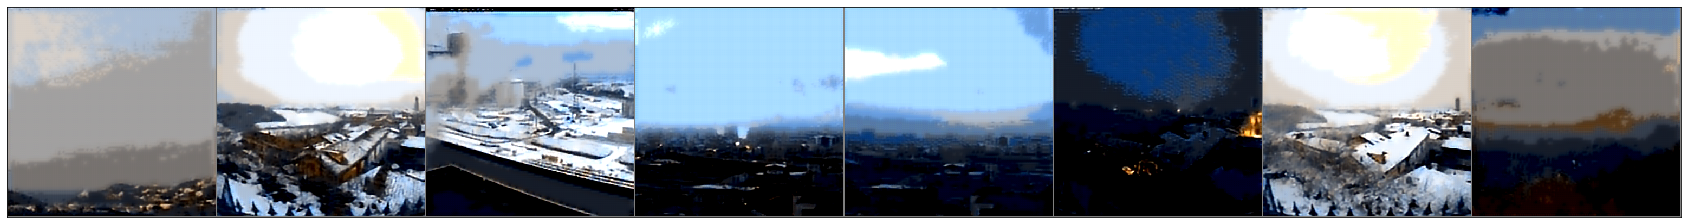

In [82]:
show(make_grid(valid_reconstructions.cpu().data)+0.5, )

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<class 'torch.Tensor'>


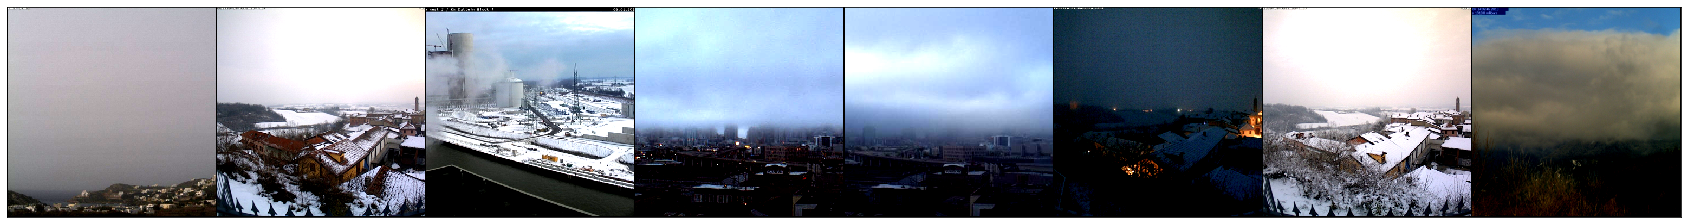

In [83]:
show(make_grid(valid_originals.cpu()+0.5))